### CricShot10 Video Classification

(Use this with permission)

- `Source` - https://drive.google.com/drive/folders/1DPHURwQk5R8blgjM8VNz6Q68LqckxljX?usp=drive_link

Notebook to set the baseline model


In [63]:
# Loading dependencies
import torch
from models import build_resnet_lstm_model
from dataset import get_dataloaders
from torchvision import transforms
from config import Config
from torchmetrics import ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
# Constants
MODEL_PATH = "real-weights/CNN-LSTM-BEST.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CONFIG = Config()

In [65]:
test_transform = transforms.Compose(
    [
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)

_, test_dataloader = get_dataloaders(
    CONFIG, train_transform=None, test_transform=test_transform
)

In [70]:
# Loading the Model
model = build_resnet_lstm_model(CONFIG)
model.load_state_dict(
    torch.load(
        MODEL_PATH,
        map_location=torch.device(DEVICE),
        weights_only=True,
    )
)
model = model.to(DEVICE)
# take care of this warning, its a dumb mistake

In [71]:
classes_to_idx = test_dataloader.dataset.class_to_idx
classes_to_idx

{'cover': 0,
 'defense': 1,
 'flick': 2,
 'hook': 3,
 'late_cut': 4,
 'lofted': 5,
 'pull': 6,
 'square_cut': 7,
 'straight': 8,
 'sweep': 9}

In [72]:
# Setup the inference on test set to get all predictions
def get_all_preds(model, dataloader, device="cpu"):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.inference_mode():
        for videos, labels in test_dataloader:
            videos = videos.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(videos)
            predicted = torch.argmax(outputs, dim=1)
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return all_preds, all_labels

In [73]:
preds, labels = get_all_preds(model, test_dataloader, DEVICE)
confmat = ConfusionMatrix(task="multiclass", num_classes=10)

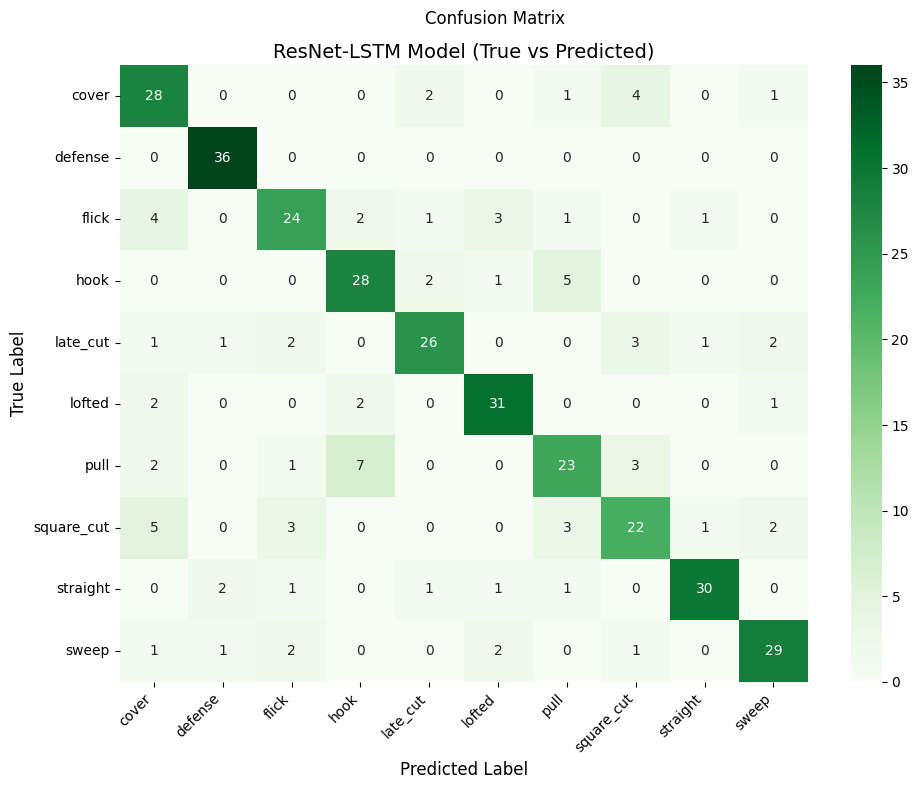

In [75]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    confmat(preds, labels),
    annot=True,
    cmap="Greens",
    xticklabels=classes_to_idx.keys(),
    yticklabels=classes_to_idx.keys(),
)

plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.title(
    "ResNet-LSTM Model (True vs Predicted)",
    fontsize=14,
)
plt.suptitle("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig("conf-mat-lstm-cnn.png")
